In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

[*********************100%%**********************]  1 of 1 completed

Date
2024-01-08    138.839996
2024-01-09    140.949997
2024-01-10    142.279999
2024-01-11    142.080002
2024-01-12    142.649994
Name: Close, dtype: float64


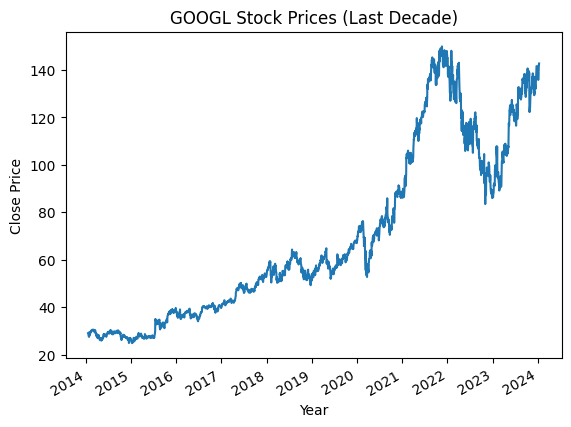

array([0.03415293, 0.03441723, 0.03343213, ..., 0.93952497, 0.93792481,
       0.94248527])

In [39]:
import yfinance as yf
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, timedelta

# replace with stock indicator
stock = 'GOOGL'

# date setters, start date 10 years ago end date now
startDate = datetime.now() - timedelta(days=365*10)
endDate = datetime.now()

# extract historical stock prices from yfinance, take only close
prices = yf.download(stock, start=startDate, end=endDate)
prices = prices['Close']

# print prices in table
print(prices.tail())

# plot prices in plot
prices.plot(title=f'{stock} Stock Prices (Last Decade)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()

# convert dates to numbers
dates = pd.to_datetime(prices.index)
dates = (prices.index - prices.index.min()).days

# scale prices between 0 and 1
prices = prices.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(prices)

prices.flatten()

# Split Train and Test
The train and test sets will be split into the following:

1. The training set will be the first 9 years.
2. The testing set will be the past year.

In [41]:
def train_test_split(prices):
    length = len(prices)

    # split point is 9 years in or 9/10 of the length, round to the nearest integer
    splitPoint = round(0.9 * length)

    # differentiate into train and test 
    train_set = prices[:splitPoint]
    test_set = prices[splitPoint:]

    return train_set, test_set

X_train, X_val = train_test_split(dates)
y_train, y_val = train_test_split(prices)

Index([   0,    1,    2,    3,    6,    7,    8,    9,   10,   13,
       ...
       3264, 3265, 3269, 3270, 3271, 3272, 3275, 3276, 3277, 3278],
      dtype='int64', name='Date', length=2262) Index([3279, 3283, 3284, 3285, 3286, 3289, 3290, 3291, 3292, 3293,
       ...
       3629, 3633, 3634, 3635, 3636, 3639, 3640, 3641, 3642, 3643],
      dtype='int64', name='Date', length=251)


The model will have one layer 128 LSTM cells, as we are taking univariate input

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # lstm layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Reshape input tensor to be 3D (batch_size, seq_len, input_dim)
        x = x.unsqueeze(1)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])

        return out

In [40]:
# define structure of model
input_dim = 1
hidden_dim = 128
num_layers = 1
output_dim = 1

# initialize model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# initialize loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 2000



IndexError: index 1 is out of bounds for dimension 0 with size 1